In [1]:
from pauls_functions_advanced import *
import pandas as pd
from sklearn.model_selection import train_test_split
from interpretableai import iai
from sklearn.metrics import accuracy_score
from pauls_functions_advanced import *
from joblib import Parallel, delayed
from scipy.stats import bernoulli

In [2]:
# logistic = np.exp(0.00001 - 0.5*x3 + 0.4*x2 - 1.1*(x2 < -0.1) * (x3 > -1) + 1.3*(x2 > -0.1)* (x6 > -1)*(x5 < 0.5))
# y = logistic/(1+logistic)

# y_bar = bernoulli.rvs(y)

$$l = e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 - \gamma_1 \mathbb{1} \{x2 < -0.1\}}$$

(array([508.,  13.,   4.,  41.,  94., 163., 243., 324., 392., 218.]),
 array([0.00551056, 0.10288713, 0.20026371, 0.29764028, 0.39501685,
        0.49239342, 0.58977   , 0.68714657, 0.78452314, 0.88189971,
        0.97927629]),
 <BarContainer object of 10 artists>)

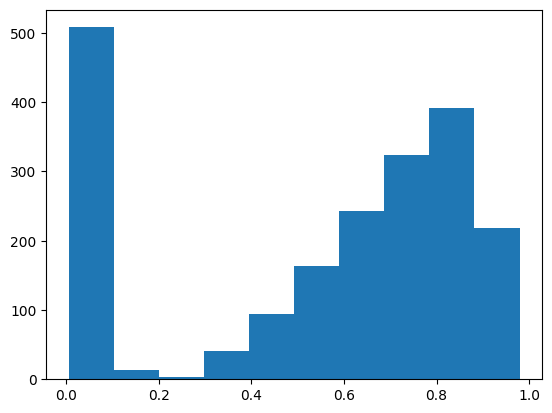

In [15]:
plt.hist(y)

In [16]:
# accuracies = pd.DataFrame(np.zeros((20, 3)))
# accuracies.columns = ['OCT', "True Model", 'CART']

names = ['Reg-CART','CART','ORT','OCT','ORT-H','OCT-H']

iters = 30

accuracies = {i: {} for i in range(iters)}

for i in range(iters):

    ## Create artificial data set with
    n = 2000
    x1 = np.random.normal(loc = 0,scale=1, size=n)
    x2 = np.random.normal(loc=0, scale=1, size=n)
    x3 = np.random.normal(loc=0, scale=1, size=n)
    x4 = np.random.normal(loc=0, scale=1, size=n)
    x5 = np.random.normal(loc = 0,scale=1, size=n)
    x6 = np.random.normal(loc=0, scale=1, size=n)
    x7 = np.random.normal(loc=0, scale=1, size=n)
    x8 = np.random.normal(loc=0, scale=1, size=n)
    x9 = np.random.normal(loc=0, scale=1, size=n)
    x10 = np.random.normal(loc=0, scale=1, size=n)

    label_not_flipped = np.random.choice([1,0], replace = True, size = n, p = [0.9, 0.1])
    
    logistic = np.exp(0.5 - 0.5*x3 + 0.4*x2 + 0.25*x1 - 0.3*x7 - 3*(x2 < -0.1) * (x3 > -1)* (x1 < 0.5) + 0.9*(x2 > -0.1)*(x6>-1)*(x5<0.5))
    y = logistic/(1+logistic)
    
    y_bar = bernoulli.rvs(y)

    y = y_bar

    simulated_data = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 
                                    'x5': x5, 'x6': x6, 'x7': x7, 'x8': x8,'x9': x9, 'x10': x10,
                                    'y': y, 'y_bar': y_bar})

    features = simulated_data[[f'x{i}' for i in range(1, 9)]]
    diagnosis = simulated_data['y']
    orig_cols = simulated_data.columns

    X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size = 0.2, random_state=i)

    models, performance = generate_tree(X_train, y_train, X_test, y_test, 
                                        n_num=2, feat_size=8,  max_iter_hy=2, 
                                        depth_bi=4, depth_hy=4, complexity_bi=0.001, 
                                        complexity_hy=0.001, depth_grid_bi=False, depth_grid_hy=False, 
                                        Reg_CART=False, ORT=False, ORT_H=False, 
                                        Clas_CART=True, OCT=True, OCT_H=False)
    
    act_name = []
    act_rules = []
    for model,name in zip(models,names):
        if not not model:
            act_name += [name]
            act_rules += [model]

    datasets = gen_train_and_test_features(act_rules, act_name, X_train, X_test)

    log_reg_acc = log_regression_pipeline(X_train, X_test, y_train, y_test)

    accuracies[i]["Logistic Regression"] = log_reg_acc

    for model in datasets.keys():

        X_train_rules_and_features, X_test_rules_and_features = datasets[model][0]
        X_train_only_rules, X_test_only_rules = datasets[model][1]

        only_rules_acc = log_regression_pipeline(X_train_only_rules, X_test_only_rules, y_train, y_test)

        rules_and_features_acc = log_regression_pipeline(X_train_rules_and_features, X_test_rules_and_features, y_train, y_test)

        accuracies[i][model + "_rules"] = only_rules_acc
        accuracies[i][model + "_rules_and_features"] = rules_and_features_acc
    
    accuracies[i]["True Model"] = accuracy_score(y_test, simulated_data.loc[y_test.index, "y_bar"])



    ----------------------------------------- section 1 -----------------------------------------
Classification CART mean performance:  0.4468367406963838


Classification OCT performance:  0.8075




    ----------------------------------------- section 2 -----------------------------------------
Classification CART mean performance:  0.4468367406963838


Classification OCT performance:  0.8025




    ----------------------------------------- section 1 -----------------------------------------
Classification CART mean performance:  0.45046849614975215


Classification OCT performance:  0.8025




    ----------------------------------------- section 2 -----------------------------------------
Classification CART mean performance:  0.45046849614975215


Classification OCT performance:  0.7875




    ----------------------------------------- section 1 -----------------------------------------
Classification CART mean performance:  0.33549830303182704


Classification OCT performanc

In [17]:
accuracies = pd.DataFrame(accuracies).T.rename(columns = {"CART_rules": "CART", "CART_rules_and_features": "RuleFit", "OCT_rules": "OCT", "OCT_rules_and_features": "ORRFA", "Logistic Regession": "Log. Regression"})

In [18]:
accuracies = accuracies.rename(columns = {"Logistic Regression": "Log. Regression"})

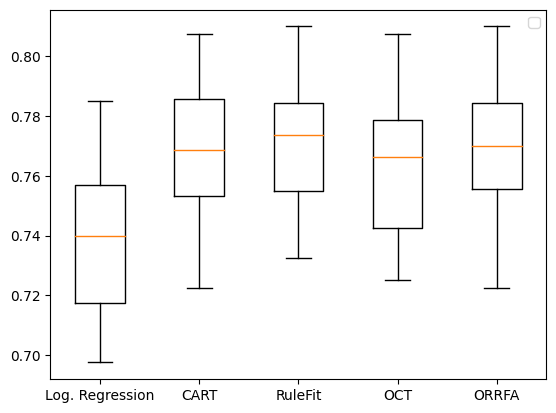

In [19]:
fig, ax = plt.subplots()


ax.boxplot(accuracies.iloc[:, :-1])
ax.set_xticklabels(accuracies.columns[:-1])

ax.legend()

In [20]:
pd.DataFrame(accuracies).T.mean()

0     0.833333
1     0.829167
2     0.769583
3     0.812083
4     0.784167
5     0.775417
6     0.807917
7     0.819583
8     0.797500
9     0.822917
10    0.808750
11    0.816250
12    0.807083
13    0.790833
14    0.786667
15    0.801250
16    0.789167
17    0.777917
18    0.794167
19    0.812500
20    0.790417
21    0.802083
22    0.796250
23    0.787917
24    0.807500
25    0.805417
26    0.791250
27    0.823750
28    0.807083
29    0.797083
dtype: float64